# Agglomerative Hierarchical Clustering

## 1.0 Initialisation

#### 1.1 Importing the libraries
Necessary libraries for dataframes, data manipulation, visualisation & machine learning algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score

#### 1.2 Loading Datasets
Necessary raw and preprocessed datasets for analysis and model building

In [3]:
df_scaled = pd.read_csv('../raw_data/customer_standard_scaled.csv', index_col='CUST_ID')
df_pca = pd.read_csv('../raw_data/customer_pca_5.csv', index_col='CUST_ID')
df_tsne = pd.read_csv('../raw_data/customer_tsne_3.csv', index_col='CUST_ID')
df_umap = pd.read_csv('../raw_data/customer_umap_3.csv', index_col='CUST_ID')

## 2.0 Model Building
#### 2.1 Functions for Visualisation & Evaluation
Helper functions to be used in the model building process

In [4]:
def plot_dendrogram(df, method='ward', cutoff_distance=None):
    linkage_matrix = sch.linkage(df, method=method)
    plt.figure(figsize=(12, 8))
    dendrogram = sch.dendrogram(linkage_matrix)
    plt.title(f'Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Samples')
    plt.ylabel('Euclidean distances')
    ax = plt.gca()
    ax.set_xticks(ax.get_xticks()[::500])  # Show every 500th label
    plt.xticks(rotation=45, fontsize=10)

    if cutoff_distance:
        plt.axhline(y=cutoff_distance, color='r', linestyle='--')
        plt.text(plt.xlim()[1], cutoff_distance, f'Cutoff: {cutoff_distance:.2f}',
                 va='center', ha='left', backgroundcolor='w')

    plt.show()

    if cutoff_distance:
        n_clusters = len(set(sch.fcluster(linkage_matrix, cutoff_distance, criterion='distance')))
        return n_clusters

def evaluate_clustering(df, labels):
    ch_score = calinski_harabasz_score(df, labels)
    return ch_score

def visualize_clusters(df, labels, axes, s=10):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2], c=labels, cmap='viridis', s=s)
    plt.colorbar(scatter).set_label('Cluster')
    ax.set_title('3D Scatter Plot of Clusters')
    ax.set_xlabel(f'{axes} 1')
    ax.set_ylabel(f'{axes} 2')
    ax.set_zlabel(f'{axes} 3')
    plt.show()

#### 2.2 Perform Clustering on different Preprocessed Datasets
To determine the best dataset for clustering <br><br>
Conclusion : \
Upon visual inspection to set cutoff distance, the UMAP dataset seems to have the best clustering structure and highest initial Calinski-Harabasz score


Clustering on Scaled dataset:


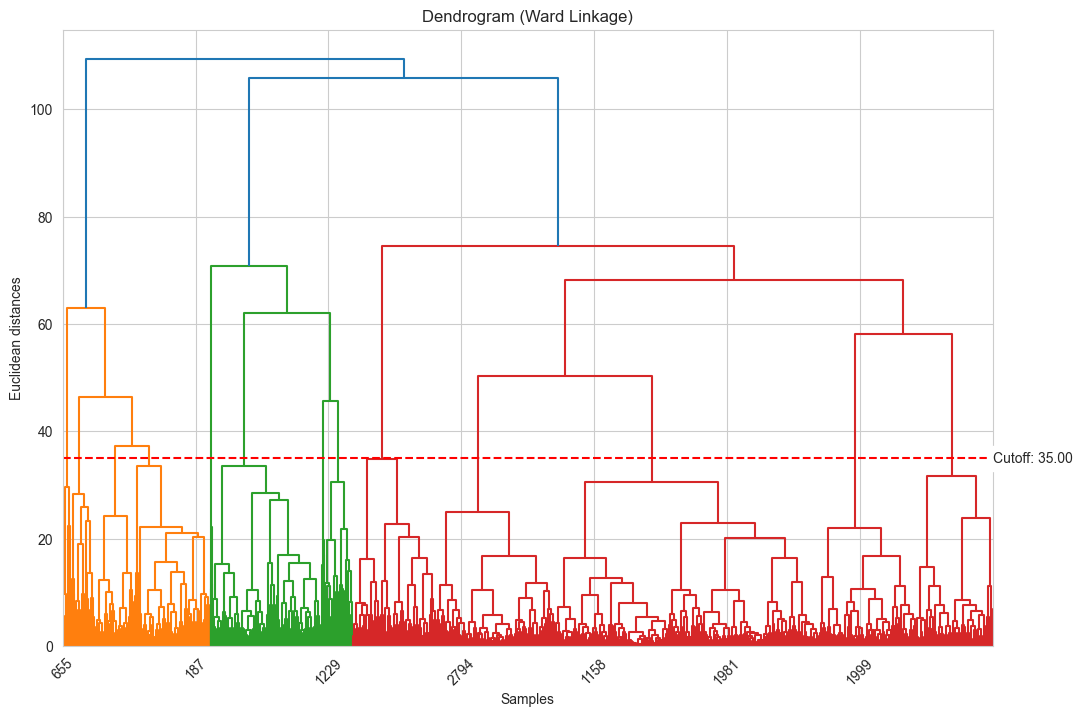

Number of clusters at cutoff distance 35: 13
Initial Calinski-Harabasz Score: 355.32102893097806


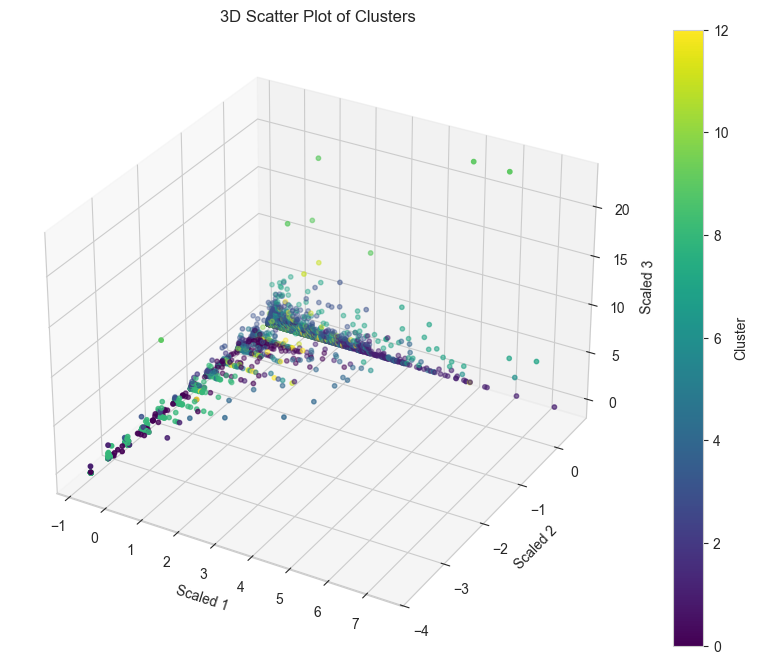


Clustering on PCA dataset:


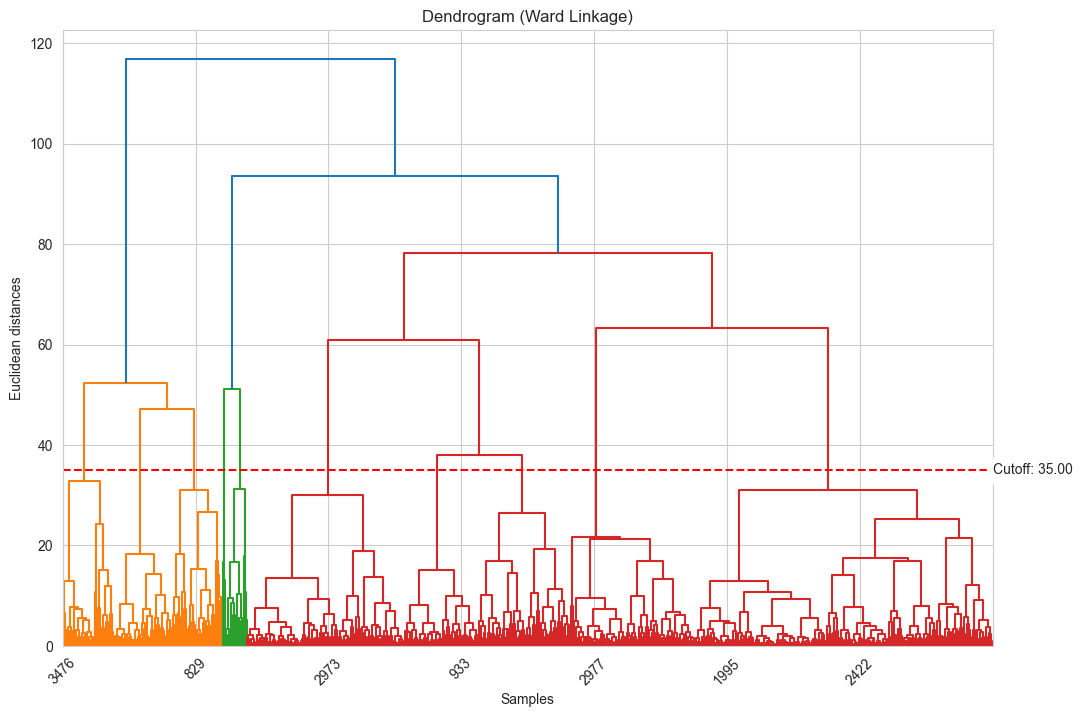

Number of clusters at cutoff distance 35: 10
Initial Calinski-Harabasz Score: 665.4985709145044


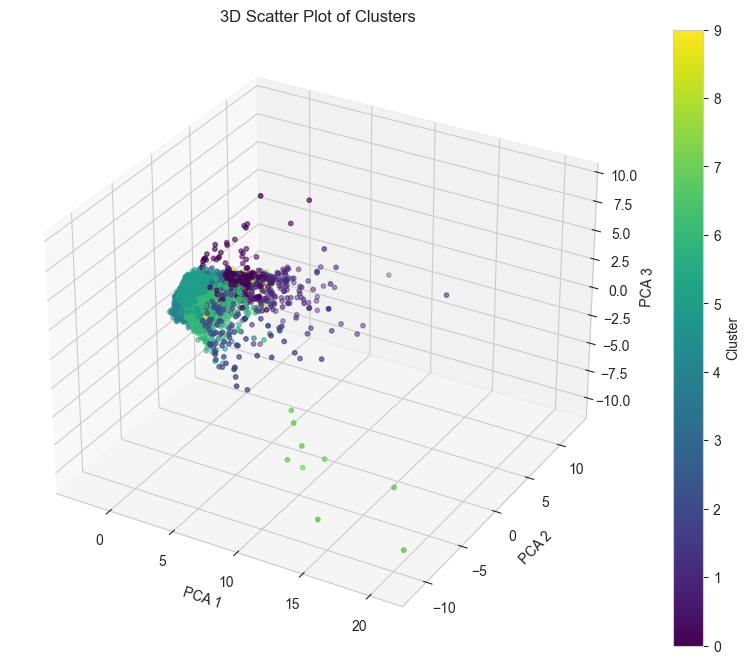


Clustering on t-SNE dataset:


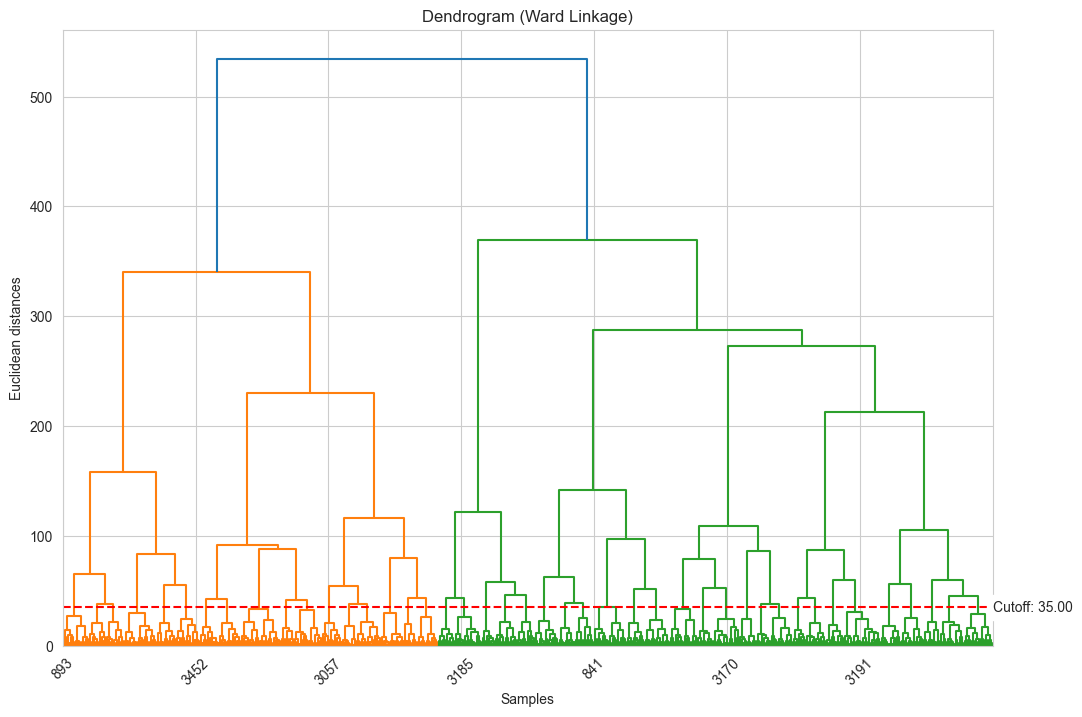

Number of clusters at cutoff distance 35: 44
Initial Calinski-Harabasz Score: 1478.3302746138495


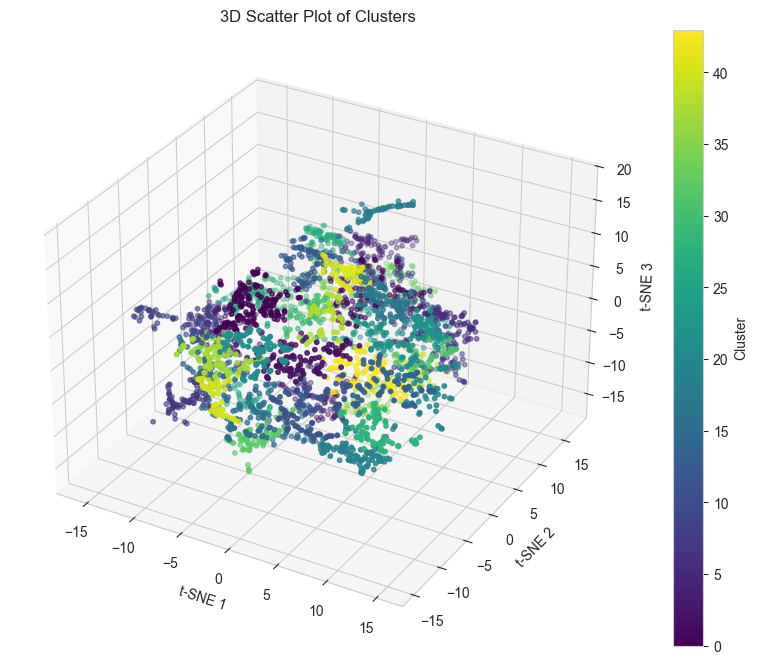


Clustering on UMAP dataset:


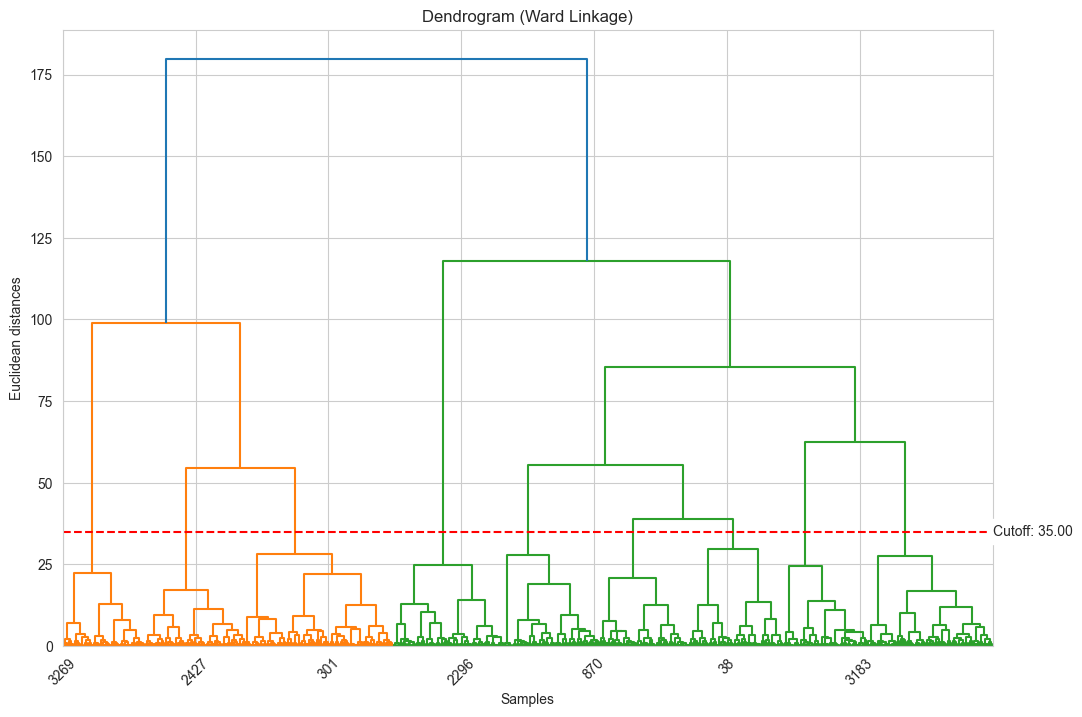

Number of clusters at cutoff distance 35: 9
Initial Calinski-Harabasz Score: 2793.8625717076316


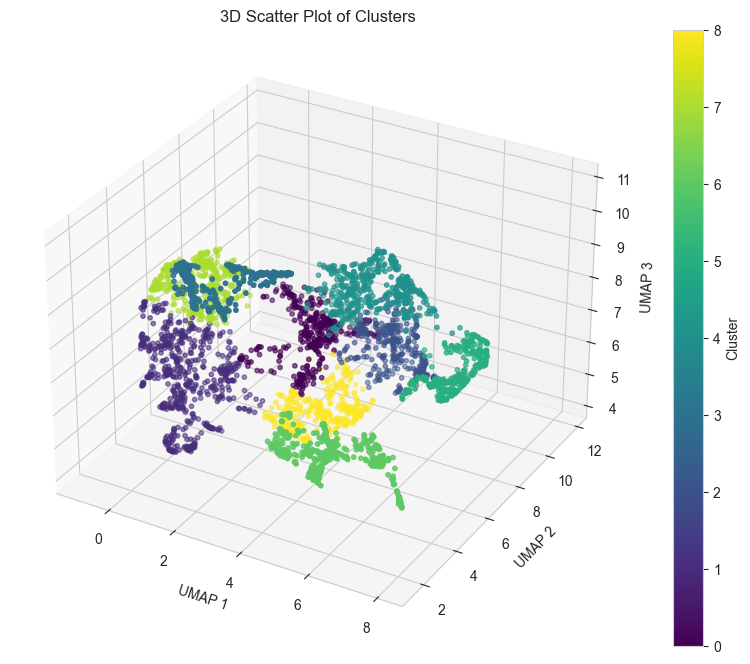

In [16]:
datasets = [
    (df_scaled, "Scaled"),
    (df_pca, "PCA"),
    (df_tsne, "t-SNE"),
    (df_umap, "UMAP")
]

for df, name in datasets:
    print(f"\nClustering on {name} dataset:")

    # Plot dendrogram with cutoff
    cutoff_distance = 35  # Can adjust this value
    n_clusters = plot_dendrogram(df, cutoff_distance=cutoff_distance)
    print(f"Number of clusters at cutoff distance {cutoff_distance}: {n_clusters}")

    # Initial clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = agg_clustering.fit_predict(df)

    # Evaluate initial clustering
    initial_ch_score = evaluate_clustering(df, labels)
    print(f"Initial Calinski-Harabasz Score: {initial_ch_score}")

    # Visualize initial clustering
    visualize_clusters(df, labels, name)

#### 2.3 Fine-tuning the Model
To determine the best parameters for the model

<b>Fine tuning the number of clusters

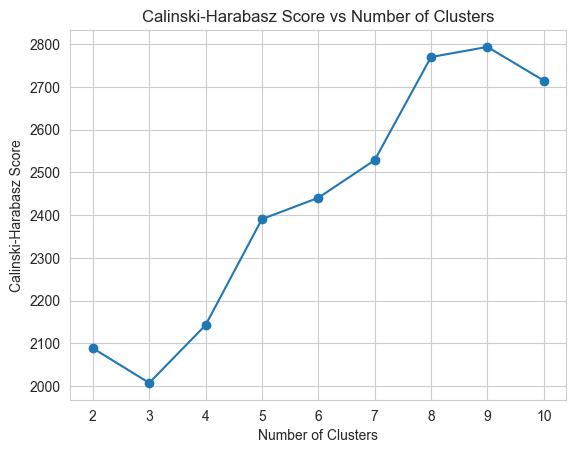

Best number of clusters: 9


In [12]:
best_df = df_umap  # Assuming UMAP performs best

# Fine-tune number of clusters
n_clusters_range = range(2, 11)
ch_scores = []

for n_clusters in n_clusters_range:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = agg_clustering.fit_predict(best_df)
    ch_scores.append(evaluate_clustering(best_df, labels))

plt.plot(n_clusters_range, ch_scores, marker='o')
plt.title('Calinski-Harabasz Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

best_n_clusters = n_clusters_range[np.argmax(ch_scores)]
print(f"Best number of clusters: {best_n_clusters}")

<b>Fine tuning the linkage method

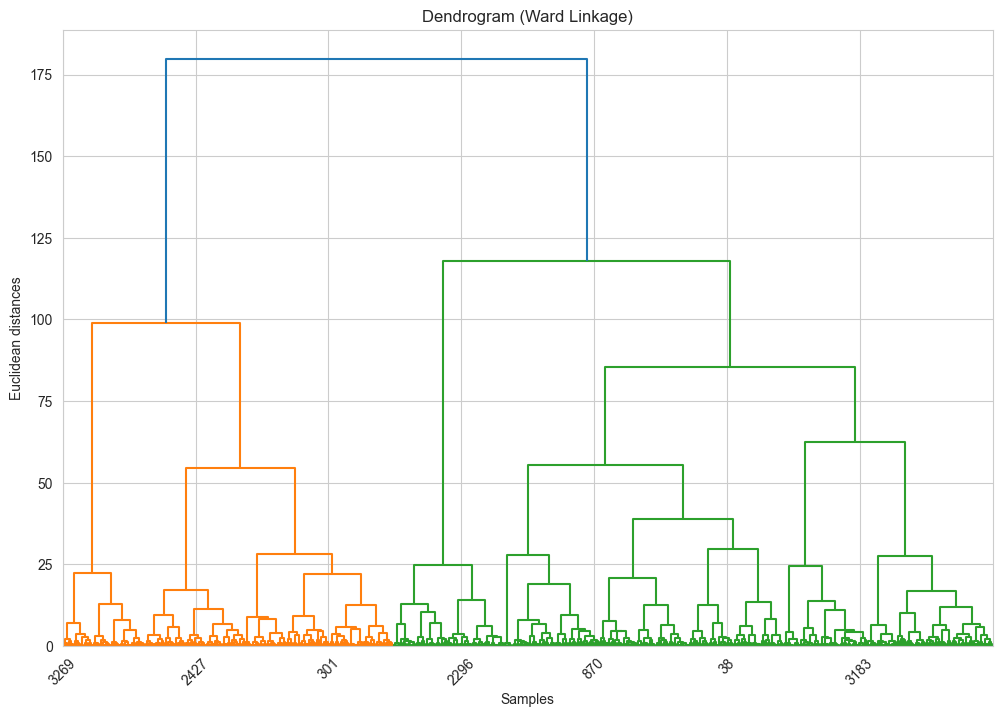

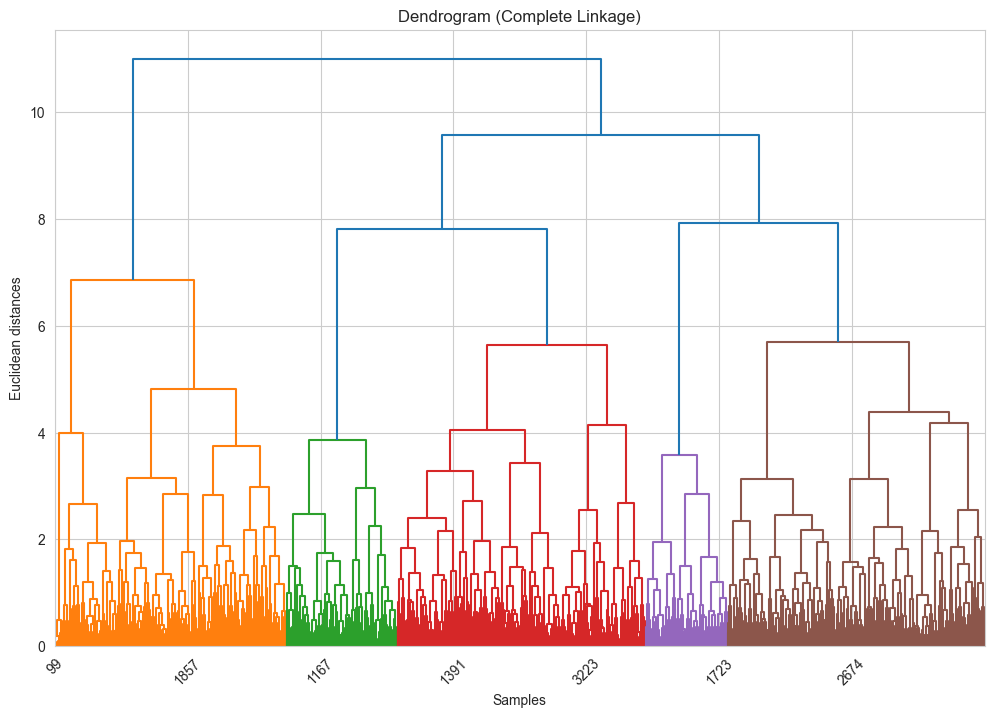

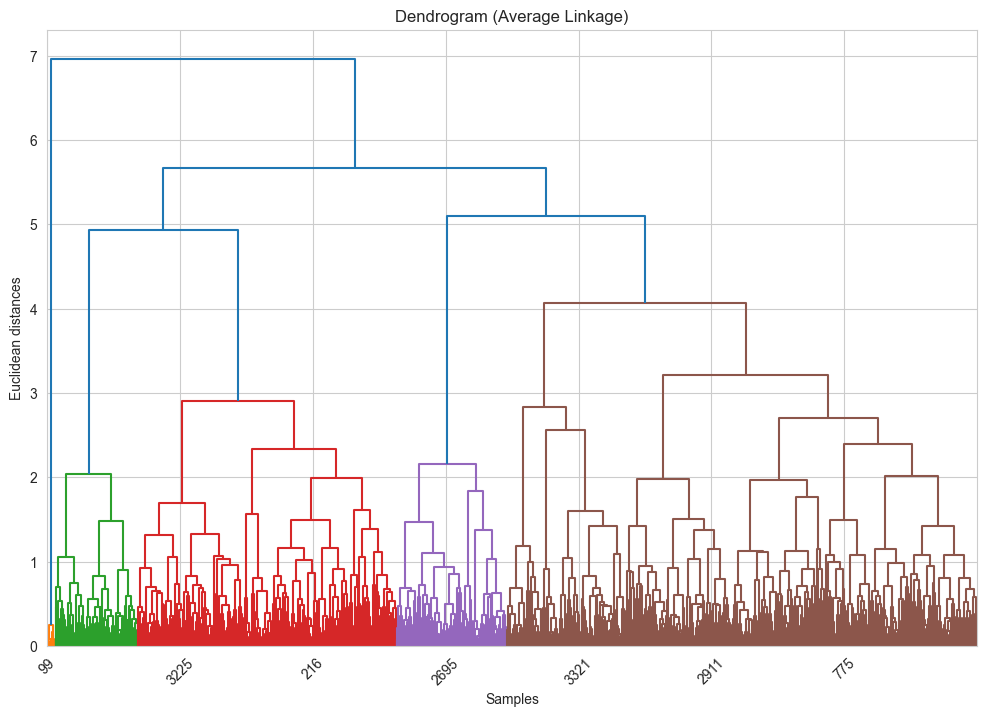

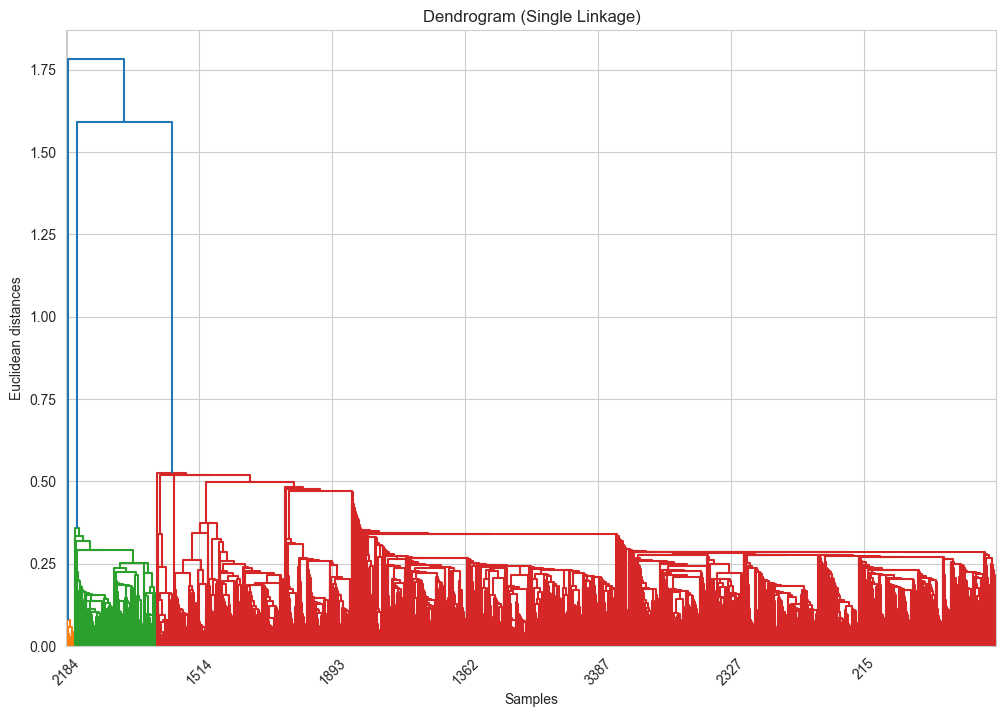

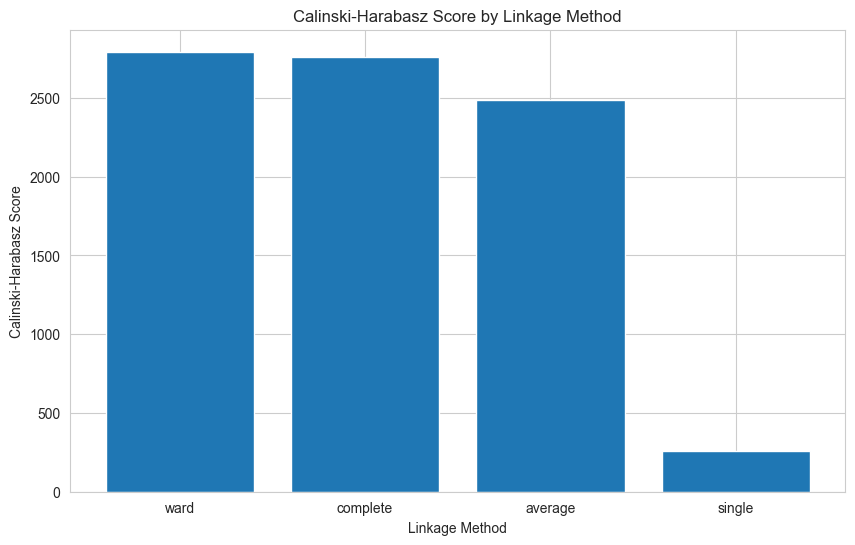

Best linkage method: ward


In [17]:
# Fine-tune linkage method
linkage_methods = ['ward', 'complete', 'average', 'single']
linkage_scores = []

for method in linkage_methods:
    agg_clustering = AgglomerativeClustering(n_clusters=best_n_clusters, metric='euclidean', linkage=method)
    labels = agg_clustering.fit_predict(best_df)
    linkage_scores.append(evaluate_clustering(best_df, labels))

    # Plot dendrogram for each linkage method
    plot_dendrogram(best_df, method=method)

plt.figure(figsize=(10, 6))
plt.bar(linkage_methods, linkage_scores)
plt.title('Calinski-Harabasz Score by Linkage Method')
plt.xlabel('Linkage Method')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

best_linkage = linkage_methods[np.argmax(linkage_scores)]
print(f"Best linkage method: {best_linkage}")

## 3.0 Final Model & Evaluation
#### 3.1 Agglomerative Hierarchical Clustering Model with Best Parameters

In [18]:
final_model = AgglomerativeClustering(n_clusters=best_n_clusters, metric='euclidean', linkage=best_linkage)
final_labels = final_model.fit_predict(best_df)

print("\nFinal model evaluation:")
print(f"Calinski-Harabasz Score: {evaluate_clustering(best_df, final_labels)}")


Final model evaluation:
Calinski-Harabasz Score: 2793.8625717076316


#### 3.2 Visualizing the Final Clusters

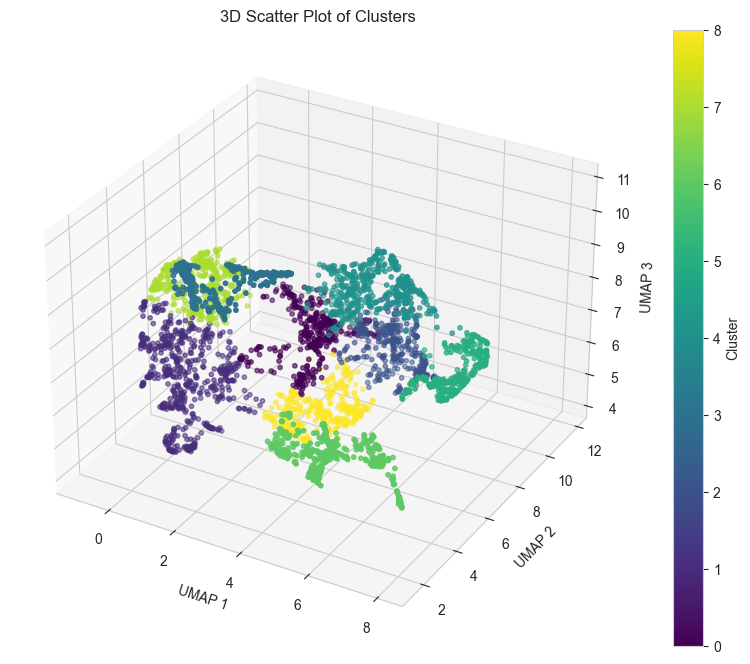


Cluster Means:
            UMAP1     UMAP2      UMAP3
Cluster                               
0        2.994768  6.832341   7.121742
1        0.279937  4.691169   5.924332
2        4.668894  8.723020   6.345855
3        2.371733  2.858076  10.183471
4        4.626160  7.308879   8.748721
5        7.460813  6.583995   7.424220
6        5.634858  2.916104   6.051058
7        0.171852  5.868572   8.207441
8        3.555694  6.362485   5.169259


In [19]:
# Visualize final clustering
visualize_clusters(best_df, final_labels, "UMAP")

# Calculate and display cluster means
best_df['Cluster'] = final_labels
cluster_means = best_df.groupby('Cluster').mean()
print("\nCluster Means:")
print(cluster_means)